# **Brain Tumor Detection by MRI Images**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip "/content/drive/MyDrive/Brain Tumor MRI Images.zip"

## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os   #for files and dir
import math
import shutil #we can move file from one file to another
import glob

In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.models import Model, load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import seaborn as sns

from keras.layers import Flatten, Dense
from keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#count the no of images in the respective classes 0 - NO Brain Tumor and 1 - Brain Tumor
ROOT_DIR = "/content/brain_tumor_dataset"
num_of_images = {}
for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [ ]:
num_of_images.items()

dict_items([('yes', 155), ('no', 98)])

In [ ]:
os.listdir("/content/brain_tumor_dataset")

['yes', 'no']

# we will split the data:
* 70% for training
* 15% for validation
* 15% for testing

In [ ]:
#we create a training folder
def dataFolder(p, split):

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                  size = (math.floor(split*num_of_images[dir])-5),
                                  replace=False ):
        O = os.path.join(ROOT_DIR,dir,img) #path
        D = os.path.join("./"+p,dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print(f"{p} folder exsist")


In [ ]:
dataFolder("train", 0.7) #new training folder

In [ ]:
dataFolder("val", 0.15) #new validation folder

In [ ]:
dataFolder("test", 0.15) #new testing folder

## Model Building

### Preparing our data using Data Generator

In [ ]:
def preprocessImages1(path):
  """
  input : Path
  output : Pre processed images    """
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range = 0.2, preprocessing_function= preprocess_input, horizontal_flip= True) #data augmentation
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [ ]:
path = "/content/train"
train_data = preprocessImages1(path)

Found 166 images belonging to 2 classes.


In [ ]:
def preprocessImages2(path):

  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [ ]:
path = "/content/test"
test_data = preprocessImages2(path)

Found 27 images belonging to 2 classes.


In [ ]:
path = "/content/val"
val_data = preprocessImages2(path)

Found 27 images belonging to 2 classes.


#Model Training

In [ ]:
base_model = MobileNet(input_shape=(224,224,3), include_top= False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

# base_model.summary()

In [ ]:
X = Flatten()(base_model.output)
X = Dense(units = 1, activation='sigmoid')(X)

model = Model(base_model.input, X)

In [ ]:
model.summary()

### Compiling the model

In [ ]:
model.compile(optimizer='rmsprop', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
#Early stoping and model check point
from keras.callbacks import  ModelCheckpoint, EarlyStopping

from keras.models import Model
#early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=5, verbose= 1)

#model check point
mc = ModelCheckpoint(monitor="val_accuracy", filepath="BrainTumor_model.h5", verbose= 1, save_best_only= True)

cd= [es,mc]


In [ ]:
EPOCH = 20
VALID = 16

## Training model



In [ ]:
hs = model.fit_generator(train_data,
                        #  steps_per_epoch= 8,
                         epochs= 30,
                         verbose= 1,
                         validation_data = val_data,
                        #  validation_steps= VALID,
                         callbacks= cd)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 6.2787e-06 - accuracy: 1.0000
Epoch 1: val_accuracy improved from 0.85185 to 0.92593, saving model to BrainTumor_model.h5
6/6 [==============================] - 3s 625ms/step - loss: 6.2787e-06 - accuracy: 1.0000 - val_loss: 1.8696 - val_accuracy: 0.9259
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 1.5990e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.92593
6/6 [==============================] - 2s 342ms/step - loss: 1.5990e-04 - accuracy: 1.0000 - val_loss: 1.8233 - val_accuracy: 0.9259
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 2.9705e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.92593
6/6 [==============================] - 2s 339ms/step - loss: 2.9705e-04 - accuracy: 1.0000 - val_loss: 1.7235 - val_accuracy: 0.9259
Epoch 4/30
5/6 [========================>.....] - ETA: 0s - loss: 1.8540e-04 - accuracy: 1.0000
Epoch 4: val_accuracy d

#Model Accuracy

In [ ]:
# #Model Accuracy
# from keras.models import load_model
# model = load_model("/content/drive/MyDrive/bestmodel.h5")

In [ ]:
acc = model.evaluate_generator(test_data)[1]
print(f"the accuracy of our model is {acc*100} %")

the accuracy of our model is 85.18518805503845 %


In [ ]:
#Model Graphical Interpretation
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

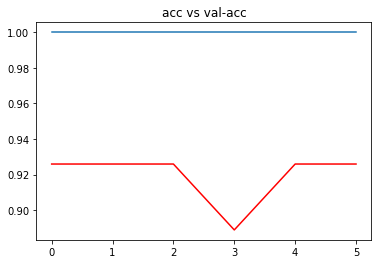

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")

plt.title("acc vs val-acc")
plt.show()

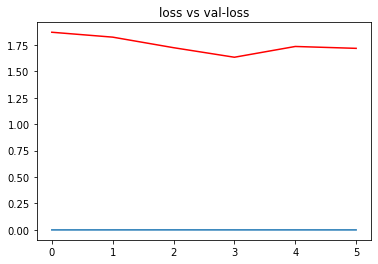

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val-loss")
plt.show()

In [ ]:
CLASS_NAMES = list(train_data.class_indices.keys())
CLASS_NAMES

['no', 'yes']

1/1 [==============================] - 0s 106ms/step
Test Accuracy: 33.333%


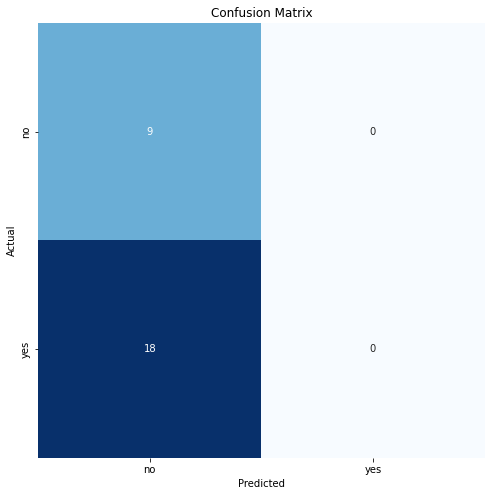

In [ ]:
predictions = np.argmax(model.predict(test_data), axis=1)

acc = accuracy_score(test_data.labels, predictions)
cm = tf.math.confusion_matrix(test_data.labels, predictions)
clr = classification_report(test_data.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 99ms/step
Validation Accuracy: 33.333%


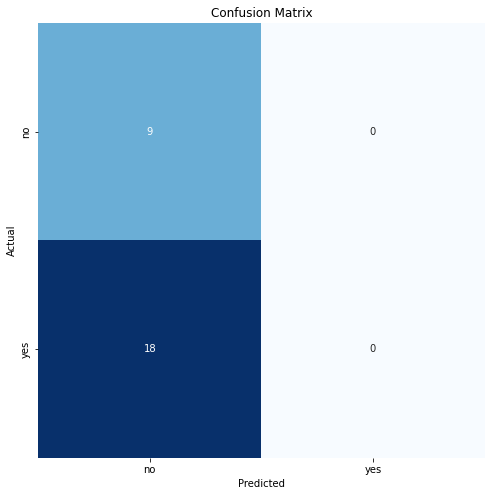

Classification Report:
----------------------
               precision    recall  f1-score   support

          no       0.33      1.00      0.50         9
         yes       0.00      0.00      0.00        18

    accuracy                           0.33        27
   macro avg       0.17      0.50      0.25        27
weighted avg       0.11      0.33      0.17        27



In [ ]:
predictions = np.argmax(model.predict(val_data), axis=1)

acc = accuracy_score(val_data.labels, predictions)
cm = tf.math.confusion_matrix(val_data.labels, predictions)
clr = classification_report(val_data.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(2) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tf.keras.utils.load_img
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

1/1 [==============================] - 0s 80ms/step


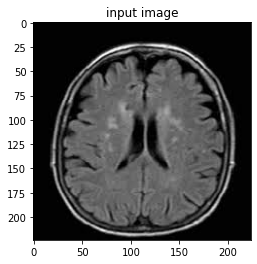

The MRI image NOT HAVING a tumor


In [ ]:

# img = image.load_img("/content/val/yes/Y169.jpg", target_size = (224,224))
img = image.load_img("/content/train/no/17 no.jpg", target_size = (224,224))


i = image.img_to_array(img)/255   #dividing by 255 for normalizing the image
# i = preprocess_input(i)
input_arr = np.array([i])
input_arr.shape
# input_arr = np.expand_dims(input_arr, axis = 0 )
# pred = model.predict(input_arr)[0][0]
# pred = np.argmax(model.predict(input_arr))


pred = (model.predict(input_arr) > 0.5)*1
# pred

# ploting image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()


# path = "/content/val/yes/Y169.jpg"

if pred == 0:
  print("The MRI image NOT HAVING a tumor")
else:
  print("The MRI image HAVING a tumor")

In [ ]:
train_data.class_indices

{'no': 0, 'yes': 1}